In [1]:
import numpy as np
import pandas as pd


import json
import os

import subprocess

from matplotlib import pyplot as plt

In [6]:
%matplotlib inline
%config Completer.use_jedi = False

In [3]:
import torch
from torch import nn
from torch import optim

from tensorboardX import SummaryWriter

In [643]:
from importlib import reload
from utils import dataset

reload(dataset)

<module 'utils.dataset' from '/Users/sergmiller/Documents/my/lux-ai-v1/research/utils/dataset.py'>

In [573]:
def learn(train, val, model_ff, criterion, epochs=5, batch_size=64, shuffle=True, freq=10,lr=1e-3, l2=1e-5, use_tb=True): 
    if use_tb:
        writer = SummaryWriter()
    
#     np.random.seed(1)
    ids_nn = np.arange(train.targets.shape[0])
    
    reshape_to_last = lambda x: torch.reshape(x, [np.prod(x.shape[:-1]), x.shape[-1]])

    optimizer = optim.Adam(model_ff.parameters(), lr=lr, weight_decay=l2)

    time_for_print_loss = lambda i: (i + 1) % freq == 0
    
    n_iter = 0


    for epoch in np.arange(epochs):
        np.random.shuffle(ids_nn)

        model_ff.train(True)

        for b in np.arange(0, train.targets.shape[0], batch_size):
            X_batch = torch.FloatTensor(train.features[ids_nn[b:b+batch_size]])
            y_batch = torch.FloatTensor(train.weights[ids_nn[b:b+batch_size]])  # reward(advantage)
            a_batch = torch.LongTensor(train.targets[ids_nn[b:b+batch_size]])  # action

            optimizer.zero_grad()
            y_pred_logits = model_ff(X_batch)

            loss = criterion(y_pred_logits, y_batch, a_batch, X_batch)
            loss.backward()

            optimizer.step()

            if (b // batch_size + 1) % freq == 0:
                print('train loss in %d epoch in %d batch: %.5f' %
                  (epoch + 1, b // batch_size + 1, loss.item()))
                
                if use_tb:
                    writer.add_scalar('data/train_loss', loss.item(), n_iter)
                    writer.add_scalar('data/epoch', epoch + 1, n_iter)
                    writer.add_scalar('data/batch', b // batch_size + 1, n_iter)

                val_loss = 0
                its = 0
                model_ff.train(False)
                for b in np.arange(0, val.targets.shape[0], batch_size):
                    its += 1
                    X_batch = torch.FloatTensor(val.features[b:b+batch_size])
#                     X_batch = reshape_to_last(X_batch)

                    y_batch = torch.FloatTensor(val.weights[b:b+batch_size])
                    a_batch = torch.LongTensor(val.targets[b:b+batch_size])
                    with torch.no_grad():
                        y_pred_logits = model_ff(X_batch)
                    loss = criterion(y_pred_logits, y_batch, a_batch, X_batch)
                    val_loss += loss.item()
                val_loss /= its
                print('val loss in %d epoch: %.5f' % (epoch + 1, val_loss))
                
                if use_tb:
                    writer.add_scalar('data/val_loss', val_loss, n_iter)
                n_iter += 1


In [96]:
datasets = dataset.read_datasets_from_dir("features_v3/")

In [97]:
dataset.read_columns_from_random_file("features_v3")

[(0, 'cargo_vol_total'),
 (1, 'cargo_fuel_total'),
 (2, 'unit_can_build'),
 (3, 'unit_routine'),
 (4, 'unit_last_action'),
 (5, 'near_city_dist'),
 (6, 'near_city_dir'),
 (7, 'near_city_fuel'),
 (8, 'near_city_light_upkeep'),
 (9, 'city_size'),
 (10, 'opp_near_city_dist'),
 (11, 'opp_near_city_dir'),
 (12, 'opp_near_city_fuel'),
 (13, 'opp_near_city_light_upkeep'),
 (14, 'opp_city_size'),
 (15, 'near_resource_dist'),
 (16, 'near_resource_dir'),
 (17, 'near_resource_type'),
 (18, 'near_resource_amount'),
 (19, 'my_city_count'),
 (20, 'opp_city_count'),
 (21, 'turn'),
 (22, 'is_night'),
 (23, 'time_to_night'),
 (24, 'width'),
 (25, 'height'),
 (26, 'my_research'),
 (27, 'opp_research'),
 (28, 'my_research_coal'),
 (29, 'opp_research_coal'),
 (30, 'my_research_uran'),
 (31, 'opp_research_uran'),
 (32, 'action'),
 (33, 'my_tiles'),
 (34, 'opp_tiles')]

In [98]:
trainD = dataset.concat_datasets(datasets[:-50])
valD = dataset.concat_datasets(datasets[-50:])

In [99]:
trainD.features[:, 4]

array(['None', 'w', 'e', ..., 'p', 'p', 'p'], dtype=object)

In [100]:
dataset.CAT_FEATURES

[2, 3, 4, 6, 11, 16, 17, 22, 28, 29, 30, 31]

In [101]:
trainD.features.shape

(2533363, 32)

In [409]:
FLOAT_FEATURES = [i for i in range(42 + 32*32*7) if i not in dataset.CAT_FEATURES_V4]

In [410]:
FLOAT_FEATURES[:20], FLOAT_FEATURES[-10:]

([0, 1, 5, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 23, 26, 27, 28],
 [7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209])

In [104]:
trainD.features.shape

(2533363, 32)

In [167]:
data = dataset.get_dataset_from_file("features_v4/features_0.07319414446710493.txt")

In [81]:
data.features.shape[1] - 32 * 32 * 7

42

In [87]:
import pickle
from sklearn.preprocessing import OneHotEncoder

In [392]:
with open("../submissions/simple/models/ohe_v2", "rb") as f:
    OHE = pickle.load(f)

In [419]:
def prepare_features(t: dataset.Dataset, v: dataset.Dataset, ohe=None, categories=None) -> (dataset.Dataset, dataset.Dataset):
    create_ohe = ohe is None
    if create_ohe:
         ohe = OneHotEncoder(sparse=False, categories=categories)
    def prepare(d, is_train):
        cf = d.features[:, dataset.CAT_FEATURES_V4]
        ff = d.features[:, FLOAT_FEATURES]
        cf[cf == "False"] = False
        cf[cf == "True"] = True
        cf[cf == None] = "None"
        cf[cf == "1"] = 1
        cf[cf == "2"] = 2
        cf[cf == "3"] = 3
        ff[ff == "None"] = 0
        cf_o = ohe.fit_transform(cf) if is_train and create_ohe else ohe.transform(cf)
        return dataset.Dataset(
            features=np.array(np.concatenate([cf_o, ff], axis=1), dtype=np.float),
            targets=np.array(d.targets, dtype=np.float),
            weights=np.array(d.weights, dtype=np.float),
            next_state_id = d.next_state_id
        )
    t = prepare(t, True)
    v = prepare(v, False)
    return (t,v, ohe)

In [171]:
data.features.shape

(6400, 7210)

In [182]:
data.features[:, dataset.CAT_FEATURES_V4][:100, 4]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, True, False, False, False, False, False, False, True,
       False, False, False, True, False, False, True, True, False, False,
       False, False, True, False, False, True, False, False, False, False,
       True, False, False, True, False, False, False], dtype=object)

In [184]:
dt,dv,OHE = prepare_features(data, data, None, [
     np.array(["None", False, True], dtype=object),
     np.array([1, 2, 3], dtype=object),
     np.array(['None', 'bcity', 'e', 'n', 'p', 's', 'w'], dtype=object),
     np.array(['None', 'c', 'e', 'n', 's', 'w'], dtype=object),
     np.array(["None", False, True], dtype=object),
     np.array(['None', 'e', 'n', 's', 'w'], dtype=object),
     np.array(["None", False, True], dtype=object),
     np.array(['None', 'c', 'e', 'n', 's', 'w'], dtype=object),
     np.array(['None', 'coal', 'uranium', 'wood'], dtype=object),
     np.array(["None", False, True], dtype=object),
     np.array(["None", False, True], dtype=object),
     np.array(["None", False, True], dtype=object),
     np.array(["None", False, True], dtype=object),
     np.array(["None", False, True], dtype=object)])

In [185]:
OHE.categories_

[array(['None', False, True], dtype=object),
 array([1, 2, 3], dtype=object),
 array(['None', 'bcity', 'e', 'n', 'p', 's', 'w'], dtype=object),
 array(['None', 'c', 'e', 'n', 's', 'w'], dtype=object),
 array(['None', False, True], dtype=object),
 array(['None', 'e', 'n', 's', 'w'], dtype=object),
 array(['None', False, True], dtype=object),
 array(['None', 'c', 'e', 'n', 's', 'w'], dtype=object),
 array(['None', 'coal', 'uranium', 'wood'], dtype=object),
 array(['None', False, True], dtype=object),
 array(['None', False, True], dtype=object),
 array(['None', False, True], dtype=object),
 array(['None', False, True], dtype=object),
 array(['None', False, True], dtype=object)]

In [186]:
dt.features.shape

(6400, 7251)

In [187]:
dt.features.shape[1] - 32 * 32 * 7

83

In [130]:
OHE.categories_

[array([False, True], dtype=object),
 array([1, 2, 3], dtype=object),
 array(['None', 'bcity', 'e', 'n', 'p', 's', 'w'], dtype=object),
 array(['c', 'e', 'n', 's', 'w'], dtype=object),
 array([False, True], dtype=object),
 array(['e', 'n', 's', 'w'], dtype=object),
 array([False, True], dtype=object),
 array(['c', 'e', 'n', 's', 'w'], dtype=object),
 array(['coal', 'uranium', 'wood'], dtype=object),
 array([False, True], dtype=object),
 array([False, True], dtype=object),
 array([False, True], dtype=object),
 array([False, True], dtype=object),
 array([False], dtype=object)]

In [188]:
# with open("../submissions/simple/models/ohe_v2", "wb") as f:
#     pickle.dump(OHE, f)

In [142]:
# with open("../submissions/simple/models/ohe_v1", "wb") as f:
#     pickle.dump(ohe, f)

In [101]:
trainD_ohe, valD_ohe = prepare_features(trainD, valD)

In [ ]:
torch.nn.Conv2d(7, )

In [626]:
MAP_F = 32 * 32 * 7

class NNWithCustomFeatures(nn.Module):
    def __init__(self, INPUT_F, DROP_P, H, A=6):
        super().__init__()
        INPUT_F_C = INPUT_F + 128
        self.model_q =  nn.Sequential(
            nn.Dropout(DROP_P),
            nn.Linear(INPUT_F_C, H),
            nn.LayerNorm(H),
            nn.ReLU(),
            nn.Dropout(DROP_P),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Dropout(DROP_P),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, A),
            nn.ReLU()
#             nn.Sigmoid()
        )
        
        self.model_p =  nn.Sequential(
            nn.Dropout(DROP_P),
            nn.Linear(INPUT_F_C, H),
            nn.LayerNorm(H),
            nn.ReLU(),
            nn.Dropout(DROP_P),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Dropout(DROP_P),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, A)
#             nn.Sigmoid()
        )
        
        self.map_model = nn.Sequential(
            nn.Conv2d(7, 64, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # after -> (16,16)
            nn.Conv2d(64, 128, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # after -> (8, 8)
            nn.Conv2d(128, 256, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # after -> (4, 4)
#             nn.Conv2d(128, 256, 3),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),  # after -> (1, 1)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.proj = nn.Sequential(
            nn.Dropout(p=DROP_P),
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=DROP_P),
            nn.Linear(256, 128)
        )
        
    def forward(self, x):
        L = x.shape[1]
        cur_r = self.forward_impl(x[:, :L // 2])
        next_r =  self.forward_impl(x[:, L // 2:])
        return torch.cat([cur_r, next_r],dim=1)

    def forward_impl(self, x):
        mapp = x[:, -MAP_F:].reshape(-1, 32, 32, 7)
        rest = x[:, :-MAP_F]
        mapp = torch.transpose(mapp, 1, -1)
        mapp = self.avgpool(self.map_model(mapp))
        mapp = torch.flatten(mapp, 1)
        mapp_f = self.proj(mapp)
#         print(mapp_f.shape)
        input_x = torch.cat([rest, mapp_f], dim=1)
#         print(input_x.shape)
#         return self.model_q(input_x)
        return torch.cat([self.model_q(input_x), self.model_p(input_x)], dim=1)

In [627]:
model = NNWithCustomFeatures(63, 0.05, 64)

In [628]:
torch.Tensor(4, 63 + 32*32*7)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [629]:
model.model_q

Sequential(
  (0): Dropout(p=0.05)
  (1): Linear(in_features=191, out_features=64, bias=True)
  (2): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
  (3): ReLU()
  (4): Dropout(p=0.05)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.05)
  (8): Linear(in_features=64, out_features=64, bias=True)
  (9): ReLU()
  (10): Linear(in_features=64, out_features=6, bias=True)
  (11): ReLU()
)

In [630]:
model.forward_impl(torch.Tensor(4, 63 + 32*32*7))

tensor([[ 0.0000,  0.0000,  0.1109,  0.0476,  0.0000,  0.0915, -0.0937, -0.0995,
         -0.1064,  0.0649,  0.0547, -0.0450],
        [ 0.0000,  0.0000,  0.1094,  0.0437,  0.0000,  0.0924, -0.0958, -0.0997,
         -0.1076,  0.0741,  0.0568, -0.0414],
        [ 0.0000,  0.0000,  0.1109,  0.0476,  0.0000,  0.0915, -0.0927, -0.0949,
         -0.1044,  0.0684,  0.0588, -0.0371],
        [ 0.0000,  0.0000,  0.1147,  0.0556,  0.0000,  0.0966, -0.0937, -0.0995,
         -0.1064,  0.0649,  0.0547, -0.0450]], grad_fn=<CatBackward>)

In [490]:
a = torch.Tensor([-1, -1 + 1e-12])
torch.allclose(a, torch.ones_like(a) * (-1))

True

In [648]:
ENTROPY_REG = 1e-4
def policy_loss(pi_logits, reward_batch, a_batch, X_batch):
    pi_probs = torch.nn.Softmax(dim=1)(pi_logits)
    return torch.mean(torch.nn.CrossEntropyLoss(reduction='none')(pi_logits, a_batch) * reward_batch 
                      - torch.sum(pi_probs * torch.log(pi_probs) * ENTROPY_REG, dim=1))

def q_loss(q_vals, reward_batch, a_batch, X_batch):
    q_vals_per_reward = q_vals[np.arange(q_vals.shape[0]), a_batch]
    return torch.nn.MSELoss()(q_vals_per_reward, reward_batch) * 0.01

gamma = 0.99

def get_is_last_state(x):
    t = torch.sum(torch.isclose(x, torch.ones_like(x) * (-1)), dim=1) == x.shape[1]
    return t.float()

def q_loss_pair(q_vals_cur_and_next, reward_batch, a_batch, X_batch):
    q_vals = q_vals_cur_and_next[:, :6]
    q_vals_next = q_vals_cur_and_next[:, 6:12]
    q_vals_per_reward_cur = q_vals[np.arange(q_vals.shape[0]), a_batch]
    X_batch_next = X_batch[:, X_batch.shape[1] // 2:]
    best_q_vals_next = torch.max(q_vals_next,dim=1)[0] * (1 - get_is_last_state(X_batch_next))
#     print(list(enumerate([q_vals_per_reward_cur, reward_batch, best_q_vals_next, q_vals_next])))
#     print(0.99 * best_q_vals_next)
#     return torch.nn.MSELoss()(target=q_vals_per_reward_cur.detach(), input=reward_batch + gamma * best_q_vals_next)
    return torch.nn.SmoothL1Loss()(target=q_vals_per_reward_cur.detach(), input=reward_batch + gamma * best_q_vals_next)


def actor_critic_loss(q_pi_payload, reward_batch, a_batch, X_batch):
    q_vals = q_pi_payload[:, :6]
    pi_logits =  q_pi_payload[:, 6:12]
    pi_probs = torch.nn.Softmax(dim=1)(pi_logits)
    q_vals_next = q_pi_payload[:, 12:18]
    q_vals_per_reward_cur = q_vals[np.arange(q_vals.shape[0]), a_batch]
    X_batch_next = X_batch[:, X_batch.shape[1] // 2:]
    best_q_vals_next = torch.max(q_vals_next,dim=1)[0] * (1 - get_is_last_state(X_batch_next))
    
    q_loss = torch.nn.SmoothL1Loss()(target=reward_batch + gamma * best_q_vals_next.detach(), input=q_vals_per_reward_cur)
    pi_loss =  torch.mean(torch.nn.CrossEntropyLoss(reduction='none')(pi_logits, a_batch) * q_vals_per_reward_cur.detach()
                      - torch.sum(pi_probs * torch.log(pi_probs) * ENTROPY_REG, dim=1))
#     print("q_loss={}, pi_loss={}".format(q_loss.item(), pi_loss.item()))
    return q_loss + pi_loss

In [506]:
t = torch.sum(torch.isclose(torch.Tensor(np.arange(9).reshape(3,3)), torch.Tensor(np.arange(9).reshape(3,3))), dim=1) == 2

In [509]:
t.float()

tensor([0., 0., 0.])

In [261]:
0.99 * torch.FloatTensor([1,2])

tensor([0.9900, 1.9800])

In [201]:
v = torch.Tensor(3,4)
v

tensor([[ 0.0000e+00,  1.5846e+29, -1.5118e-05, -8.5920e+09],
        [ 4.2039e-45,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.7551e-40]])

tensor([1, 2, 1])

In [216]:
v[np.array([0,1,2]), torch.LongTensor([1,0,3])].shape

torch.Size([3])

In [ ]:
learn(trainD_ohe, valD_ohe, model, policy_loss, lr=1e-4, batch_size=32, epochs=5, freq=64, l2=1e-5)

train loss in 1 epoch in 64 batch: 33.62749
val loss in 1 epoch: 27.46838
train loss in 1 epoch in 128 batch: 33.35194
val loss in 1 epoch: 27.00126
train loss in 1 epoch in 192 batch: 27.84943
val loss in 1 epoch: 26.51209
train loss in 1 epoch in 256 batch: 33.79417
val loss in 1 epoch: 25.98330
train loss in 1 epoch in 320 batch: 21.44173
val loss in 1 epoch: 25.44491
train loss in 1 epoch in 384 batch: 37.08883
val loss in 1 epoch: 24.86610
train loss in 1 epoch in 448 batch: 32.10423
val loss in 1 epoch: 24.28592
train loss in 1 epoch in 512 batch: 32.83151
val loss in 1 epoch: 23.70958
train loss in 1 epoch in 576 batch: 28.95453
val loss in 1 epoch: 23.13052
train loss in 1 epoch in 640 batch: 23.10432
val loss in 1 epoch: 22.59232
train loss in 1 epoch in 704 batch: 27.52392
val loss in 1 epoch: 22.07282
train loss in 1 epoch in 768 batch: 20.83056
val loss in 1 epoch: 21.61408
train loss in 1 epoch in 832 batch: 25.31148
val loss in 1 epoch: 21.17967
train loss in 1 epoch in 8

In [54]:
torch.Tensor([1,2,0])

tensor([1., 2., 0.])

In [57]:
torch.randn(2, 3)

tensor([[-1.8303,  0.1936,  0.8113],
        [ 0.8070, -0.6903, -0.6328]])

In [58]:
torch.nn.CrossEntropyLoss(reduction='none')(torch.randn(2, 3), torch.LongTensor([1,2]))

tensor([2.6177, 0.9913])

In [186]:
torch.save(model.state_dict(), '../submissions/simple/models/policy_v1')

In [181]:
model.forward(torch.Tensor(trainD_ohe.features[0]).reshape(1, -1))

tensor([[  4.7694, -46.3936,  -7.7365,  -9.8257,   0.2452,  59.4586]],
       grad_fn=<ThAddmmBackward>)

In [184]:
p = model.forward(torch.Tensor(trainD_ohe.features[0]).reshape(1, -1)).cpu().detach().numpy().reshape(-1)
p = np.clip(p, -30, 30)

In [185]:
np.exp(p) / np.sum(np.exp(p))

array([1.10283675e-11, 8.75651089e-27, 4.08547019e-17, 5.05711219e-18,
       1.19576061e-13, 1.00000000e+00], dtype=float32)

In [148]:
trainD.features[0]

array([0, 0, False, 2, 'None', 0, 'c', 0.0, 23.0, 1, 1, 'n', 0.0, 23.0, 1,
       1, 'w', 'wood', 800, 1, 1, 0, False, 30, 16, 16, 0, 0, False,
       False, False, False], dtype=object)

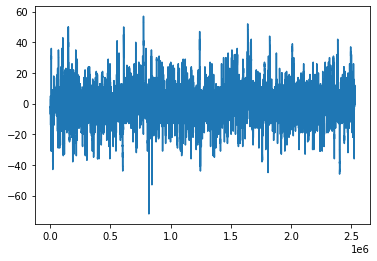

In [151]:
plt.plot(trainD.weights)

In [429]:
simple_bot = "../submissions/simple/main.py"
replays = "replays"

def run_game(left_bot=simple_bot, right_bot=simple_bot, seed=42, loglevel=2):
    replay_path = "replay.json"
    python_v = "python3.7"
    
    replay_path = os.path.join(replays, str(np.random.randint(1e9)) + ".json")
    
    size = np.random.choice([12,16,24,32], size=1)[0]
    
    res = subprocess.run([
        "lux-ai-2021",
        left_bot,
        right_bot,
#         "--statefulReplay",
        "--width={}".format(size),
        "--height={}".format(size),
        "--loglevel={}".format(loglevel),
        "--python={}".format(python_v),
        "--maxtime=100000",
        "--maxConcurrentMatches=1",
        "--seed={}".format(seed),
        "--out={}".format(replay_path)], stdout=subprocess.PIPE)
    
    if loglevel > 0:
        print(res.stdout.decode())

    assert res.returncode == 0

    with open(replay_path, "r") as f:
        result = json.load(f)
    return result, res.stdout.decode()

In [432]:
# run_game(simple_bot, simple_bot)

In [98]:
import hashlib

def build_runnable_bot_with_flags(flags: dict, origin = simple_bot, base_path = '../submissions/simple/') -> str:
    lines = []
    with open(origin, "r") as f:
        for line in f:
            lines.append(line[:-1])
    text = '\n'.join(lines)
    f = json.dumps(flags)
    text = text.format(f)
    h = int(hashlib.sha256(f.encode('utf-8')).hexdigest(), 16) % (10 ** 18)
    path = base_path + "main_" + str(h) + ".py"
    with open(path, "w") as f:
        f.write(text)
    return path

In [229]:
def count_series(results: list):
    wins = []
    for i, r in enumerate(results):
        ranks = r[0]['results']['ranks']
        teams = r[0]['teamDetails']
        if ranks[0]['rank'] == 1 and ranks[1]['rank'] == 2:
            if ranks[0]["agentID"] == i % 2:
                wins.append(1)
            else:
                wins.append(0)
        else:
            wins.append(0.5)
    return wins

In [100]:
from joblib import Parallel, delayed
import tqdm

In [614]:
def sample_dataset(d, p=0.5):
    N = len(d.features)
    ids = np.random.choice(N, size=int(N * p))
    return dataset.Dataset(features = d.features[ids], weights = d.weights[ids], targets = d.targets[ids])

In [492]:
def add_next_features(d):
    assert d.next_state_id is not None
    coupled_features = []
    weights = []
    targets = []
    for i in np.arange(d.features.shape[0]):
        next_i = d.next_state_id[i]
        if d.next_state_id[i] != -1:
            next_f = d.features[next_i]
        else:
            next_f = np.ones_like(d.features[i]) * (-1)
        coupled_features.append(np.concatenate([d.features[i], next_f]))
        weights.append(d.weights[i])
        targets.append(d.targets[i])
    return dataset.Dataset(
        features=np.array(coupled_features),
        weights=np.array(weights),
        targets=np.array(targets))

In [407]:
FLOAT_FEATURES[-10:]

[7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209]

In [408]:
trainD.features.shape

(38, 7209)

In [ ]:
t = 0  #  1778 - value_iter
B = 1

model = NNWithCustomFeatures(83, 0.05, 64)

writer = SummaryWriter()

while True:
    t += 1
    np.random.seed(t)
    torch.save(model.state_dict(), '../submissions/simple/models/ac_iter_v{}'.format(t))
    r = []
    for i in np.arange(B):
        seed = t * B + i
        _f = str(seed) + ".txt"
        bot = build_runnable_bot_with_flags({
            "model_path": "models/ac_iter_v{}".format(t), 
            "use_policy": True,
            "is_neural": True,
            "prob_use_default_agent": 0.5 / np.log(t + 1),
            "prob_use_random": 0.05,
            "ohe_path": "models/ohe_v2",
            "use_old_units_cargo_rules": False,
            "log_features_path": "../../research/features_iter/", "log_path_file_name": _f
        })
        if t % 2 == 0:
            _r = run_game(bot, simple_bot, loglevel=0, seed=seed)
        else:
            _r = run_game(simple_bot, bot, loglevel=0, seed=seed)
        r.append(_r)
    wins = np.mean(count_series(r))
    if t % 2 == 1:
        wins = 1 - wins
    trainD = dataset.get_dataset_from_file(os.path.join("features_iter/", _f), wins)
    reward = np.sum(trainD.weights)
    trainD_ohe, valD_ohe, _ = prepare_features(trainD, trainD, OHE)
    max_step = np.max(trainD.features[:, 31])
    trainD_ohe_with_next = add_next_features(trainD_ohe)
    valD_ohe_with_next = add_next_features(valD_ohe)
    trainD_ohe_with_next_sampled = sample_dataset(trainD_ohe_with_next, 0.1)
    print("Round {}, winrate: {}, max_step: {}, reward: {}, example: {}".format(t, wins, max_step, reward, r[0][0]['results']))
    writer.add_scalar('data/reward', reward, t)
    writer.add_scalar('data/winrate', wins, t)
    writer.add_scalar('data/max_step', max_step, t)
    try:
        learn(trainD_ohe_with_next_sampled, valD_ohe_with_next, model, actor_critic_loss, lr=1e-1 / (t+1), batch_size=64, epochs=1, freq=1, l2=1e-5, use_tb=False)
    except Exception as e:
        print(e)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 1, winrate: 0.0, max_step: 359, reward: 0.26289999999999836, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/717354021.json'}
train loss in 1 epoch in 1 batch: 0.04858
val loss in 1 epoch: 22.23305
train loss in 1 epoch in 2 batch: 31.29694
val loss in 1 epoch: 1.07178


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 2, winrate: 0.0, max_step: 310, reward: 1.7673000000000298, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/798842024.json'}
train loss in 1 epoch in 1 batch: 0.89470
val loss in 1 epoch: 6.25246
train loss in 1 epoch in 2 batch: 6.39071
val loss in 1 epoch: 18.49046
train loss in 1 epoch in 3 batch: 18.13600
val loss in 1 epoch: 13.67970


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 3, winrate: 0.0, max_step: 359, reward: 0.9316999999999964, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/218175338.json'}
train loss in 1 epoch in 1 batch: 16.02784
val loss in 1 epoch: 46.59298
train loss in 1 epoch in 2 batch: 46.14453
val loss in 1 epoch: 57.88479
train loss in 1 epoch in 3 batch: 57.39045
val loss in 1 epoch: 86.11944
Round 4, winrate: 0.0, max_step: 359, reward: 0.6188999999999972, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/932136058.json'}
train loss in 1 epoch in 1 batch: 82.17757
val loss in 1 epoch: 89.83972
train loss in 1 epoch in 2 batch: 88.25482
val loss in 1 epoch: 71.09046


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 5, winrate: 0.0, max_step: 238, reward: 0.03640000000000006, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/953453411.json'}
train loss in 1 epoch in 1 batch: 65.57085
val loss in 1 epoch: 132.50782


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 6, winrate: 0.0, max_step: 350, reward: 0.20019999999999885, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/613579658.json'}
train loss in 1 epoch in 1 batch: 88.05369
val loss in 1 epoch: 64.98711
Round 7, winrate: 0.0, max_step: 110, reward: 0.0038999999999999972, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/327741615.json'}
train loss in 1 epoch in 1 batch: 31.80294
val loss in 1 epoch: 193.95966
Round 8, winrate: 0.0, max_step: 79, reward: 0.013100000000000006, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/530125251.json'}
train loss in 1 epoch in 1 batch: 33.32146
val loss in 1 epoch: 86.04759


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 9, winrate: 0.0, max_step: 319, reward: 0.045200000000000295, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/44556670.json'}
train loss in 1 epoch in 1 batch: 190.91922
val loss in 1 epoch: 84.81249
Round 10, winrate: 0.0, max_step: 196, reward: 0.0127, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/91571465.json'}
train loss in 1 epoch in 1 batch: 93.79315
val loss in 1 epoch: 111.41048


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 11, winrate: 1.0, max_step: 314, reward: 4.190800000000001, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/774252441.json'}
train loss in 1 epoch in 1 batch: 909.19666
val loss in 1 epoch: 668.16833
Round 12, winrate: 0.0, max_step: 29, reward: 0.004200000000000001, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/662124363.json'}
train loss in 1 epoch in 1 batch: 1065.47693
val loss in 1 epoch: 690.68457
Round 13, winrate: 0.0, max_step: 156, reward: 0.011399999999999987, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/118980946.json'}
train loss in 1 epoch in 1 batch: 36.81111
val loss in 1 epoch: 29.70477


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 14, winrate: 0.0, max_step: 150, reward: 0.026599999999999947, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/59886187.json'}
train loss in 1 epoch in 1 batch: 27.43460
val loss in 1 epoch: 83.40161
Round 15, winrate: 0.0, max_step: 112, reward: 0.006100000000000003, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/424418760.json'}
train loss in 1 epoch in 1 batch: 18.55710
val loss in 1 epoch: 59.74951
Round 16, winrate: 0.0, max_step: 276, reward: 1.0378999999999987, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/959027881.json'}
train loss in 1 epoch in 1 batch: 1361.95618
val loss in 1 epoch: 1147.46030
train loss in 1 epoch in 2 batch: 1077.70996
val loss in 1 epoch: 970.36043
train loss in 1 epoch in 3 batch: 1071.70105
val loss in 1 epoch: 820.92862


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 17, winrate: 0.0, max_step: 279, reward: 0.02479999999999996, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/191834735.json'}
train loss in 1 epoch in 1 batch: 142.05771
val loss in 1 epoch: 116.36702


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 18, winrate: 0.0, max_step: 310, reward: 0.16959999999999825, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/645852458.json'}
train loss in 1 epoch in 1 batch: 481.06995
val loss in 1 epoch: 411.30109
train loss in 1 epoch in 2 batch: 410.80725
val loss in 1 epoch: 377.32683
Round 19, winrate: 0.0, max_step: 155, reward: 0.02629999999999989, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/418903645.json'}
train loss in 1 epoch in 1 batch: 433.30289
val loss in 1 epoch: 333.89712
Round 20, winrate: 0.0, max_step: 191, reward: 0.11519999999999932, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/378518883.json'}
train loss in 1 epoch in 1 batch: 344.16223
val loss in 1 epoch: 330.41922
Round 21, winrate: 0.0, max_step: 310, reward: 0.031599999999999906, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replay

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 22, winrate: 0.0, max_step: 190, reward: 0.01089999999999999, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/895331189.json'}
train loss in 1 epoch in 1 batch: 246.15454
val loss in 1 epoch: 209.60680
Round 23, winrate: 0.0, max_step: 196, reward: 0.9099000000000081, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/74293843.json'}
train loss in 1 epoch in 1 batch: 312.94333
val loss in 1 epoch: 260.40880
train loss in 1 epoch in 2 batch: 252.52475
val loss in 1 epoch: 246.79204
Round 24, winrate: 0.0, max_step: 30, reward: 0.0020000000000000005, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/902017442.json'}
train loss in 1 epoch in 1 batch: 479.45038
val loss in 1 epoch: 566.68054
Round 25, winrate: 0.0, max_step: 359, reward: 0.6505999999999864, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFil

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Round 35, winrate: 0.0, max_step: 359, reward: 0.46479999999999866, example: {'ranks': [{'rank': 1, 'agentID': 0}, {'rank': 2, 'agentID': 1}], 'replayFile': 'replays/893589193.json'}
train loss in 1 epoch in 1 batch: 226.86462
val loss in 1 epoch: 139.03641
train loss in 1 epoch in 2 batch: 166.25969
val loss in 1 epoch: 132.11613
Round 36, winrate: 0.0, max_step: 310, reward: 0.06390000000000017, example: {'ranks': [{'rank': 1, 'agentID': 1}, {'rank': 2, 'agentID': 0}], 'replayFile': 'replays/981430917.json'}
train loss in 1 epoch in 1 batch: 132.91501
val loss in 1 epoch: 80.78207


In [394]:
trainD.features.shape

(486, 7208)

In [164]:
trainD.features[:100, dataset.CAT_FEATURES_V4][:, 4]

array(['False', 'False', 'False', 'False', 'False', 'False', 'False',
       'False', 'False', 'False', 'False', 'False', 'False', 'False',
       'False', 'False', 'False', 'None', False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       True, True, True, True, True, True, True, True, True, True, True,
       True, True, True, True, True, True, True, True, True, True, True,
       True, True, True, True, True, True, True, True, True, True, True,
       True, True, True, True, True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False], dtype=object)

In [266]:
print(trainD_ohe_with_next.features.shape, trainD_ohe_with_next.weights.shape, trainD_ohe_with_next.targets.shape)

(132, 14502) (131,) (132,)


In [267]:
trainD_ohe.features.shape

(133, 7251)

In [268]:
trainD_ohe.targets.shape

(133,)

In [269]:
trainD_ohe.weights.shape

(131,)

In [270]:
trainD.weights.shape

(131,)

In [621]:
trainD_ohe_with_next_sampled.features.shape

(138, 14502)

In [623]:
trainD_ohe_with_next.features

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ..., -1., -1., -1.]])